In [1]:
from typing import Any, Callable, Dict, List
import sys, os, pathlib
from pathlib import Path

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.utils import save_image
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar, LearningRateMonitor

import pmldiku
from pmldiku import data, model_utils, output_utils, fid


%load_ext autoreload
%autoreload 1
%aimport pmldiku.data, pmldiku.diffusion, pmldiku.diffusion_utils

In [2]:
torch.manual_seed(1)

cuda = True
batch_size = 128
epochs = 200 # 200
device_name = "cuda" if cuda else "cpu"

device = torch.device(device_name)
kwargs = {'num_workers': 4, 'pin_memory': device} 

code_path = Path(os.getcwd()).parent.parent
print(code_path)


/scratch/pcv439/pmldiku-exam-paper/code


In [3]:
train_loader = data.load_mnist(train=True).setup_data_loader(batch_size=batch_size, **kwargs)
validation_loader = data.load_mnist(train=False).setup_data_loader(batch_size=batch_size, **kwargs)

In [4]:
classifier: fid.MNISTClassifier = fid.MNISTClassifier()

In [5]:

cb_model_checkpoint, cb_early_stopping, cb_progress_bar, cb_lr_monitor, cb_class_loss = (
    ModelCheckpoint(), EarlyStopping('val_mse'), 
    TQDMProgressBar(), LearningRateMonitor('step'),
    fid.ClassifierLossCallback())  

callbacks = [cb_model_checkpoint, cb_early_stopping, cb_progress_bar, cb_lr_monitor, cb_class_loss]


trainer = pl.Trainer(max_epochs=epochs, devices=1, accelerator=device_name, auto_lr_find=True, callbacks=callbacks)
trainer.fit(model=classifier, train_dataloaders=train_loader, val_dataloaders=validation_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 21.8 K
-------------------------------
21.8 K    Trainable params
0         Non-trainable params
21.8 K    Total params
0.087     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/scratch/pcv439/pmldiku-exam-paper/code/src/pmldiku/fid.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.3234443962574005


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.25009432435035706


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.20836132764816284


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.19429360330104828


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.2053460329771042


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.16765812039375305


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1603001356124878


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.16483886539936066


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1566447913646698


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.15149736404418945


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.13392426073551178


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1285729855298996


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.13474060595035553


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1317579448223114


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1322750598192215


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.13944567739963531


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.12812697887420654


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.11670251935720444


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.12710808217525482


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.11727342009544373


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1317037045955658


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.12178611010313034


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1332966834306717


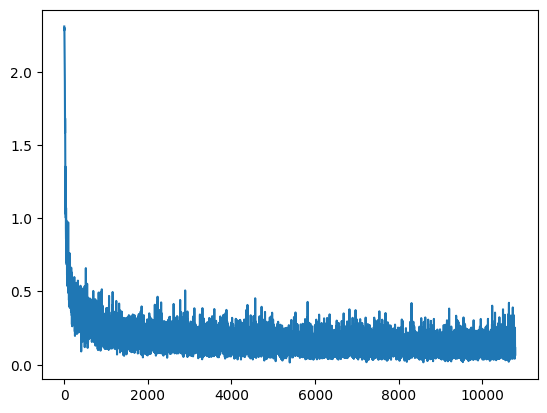

In [6]:
plt.plot(cb_class_loss.train_loss)

In [7]:
# getting new larger image tensor for FID

batch_size = 10000
validation_loader = data.load_mnist(train=False).setup_data_loader(batch_size=batch_size, **kwargs)
batch = next(iter(validation_loader))

In [8]:
X_true, y_true = batch
y_hat = classifier.model(X_true)


In [9]:
# performance in validation set
n_correct = fid.avg_correct_label(y_hat.detach().argmax(1), y_true)
n_correct

0.9645

# Calculating FIDS

- Overvej om skyde det her hen i en anden notebook hvor vi udregner fids

In [10]:
FSO = output_utils.FIDScoreOutput(n_decimals=2)

In [11]:

# bernoulli with p = 0.9 reasonable baseline
X_baseline = torch.bernoulli(torch.ones(10000, 1, 28, 28)*0.09)

tensor_path = code_path / pathlib.Path('output/image-tensors') 

model_utils.save_image_tensor(X_baseline, tensor_path, 'baseline.pkl')


In [12]:
frechet_inception_distance = fid.FID(classifier)
FSO = output_utils.FIDScoreOutput(n_decimals=2)

In [20]:
# HER SKAL ALLE ANDRE BILLEDE TENSOR LOADES. De skal have dimensionen (10, 1, 28, 28)

X_baseline = model_utils.load_image_tensor(tensor_path, 'baseline.pkl')
X_vae = None #indsæt
X_vbae = None #indsæt
X_cvea = None #indsæt
X_diff = None #indsæt
X_unet_diffusion: torch.Tensor = model_utils.load_image_tensor(tensor_path, 'unet_diffusion.pkl')
X_conv_diffusion: torch.Tensor = model_utils.load_image_tensor(tensor_path, 'convnet_diffusion.pkl')



In [21]:
# skal også indsættes for de andre

score, info = frechet_inception_distance.calculate_fid(X_true, X_baseline)

#score_vae, info_vae = frechet_inception_distance.calculate_fid(X_true, X_vae)
#FSO.add('vae', score_vae)

unet_score, unet_info = frechet_inception_distance.calculate_fid(
    X_true, X_unet_diffusion)
FSO.add('UNet Diffusion ', unet_score)

diff_conv_score, diff_conv_info = frechet_inception_distance.calculate_fid(
    X_true, X_conv_diffusion)
FSO.add('Conv Diffusion', diff_conv_score)


In [22]:
p = os.getcwd()

table = FSO.generate_table()

with open(pathlib.Path(p).parent.parent / pathlib.Path('tables') / pathlib.Path('fso_comparison.tex'), 'w') as table_file:
    table_file.write(table)

print(FSO.memory)

{'Baseline': [tensor(1377.8665)], 'UNet Diffusion ': [tensor(1699.8668)], 'Conv Diffusion': [tensor(467.3229)]}


/scratch/pcv439/pmldiku-exam-paper/code/src/pmldiku/output_utils.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return table.to_latex(float_format="%.{}f".format(self.n_decimals))


# Plot helping

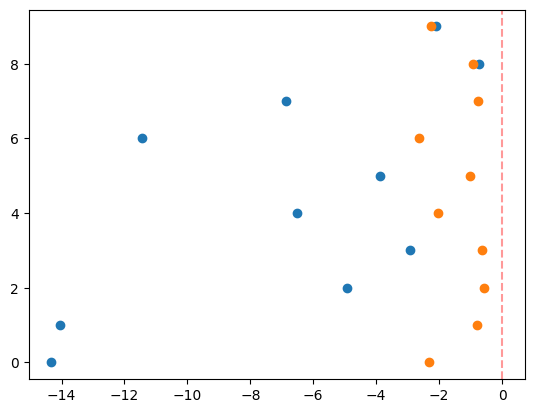

In [16]:
feature_ix = list(range(10))

plt.axvline(0, ls='--', color='red', alpha=0.4)

plt.scatter(info['mu_real'], feature_ix)
plt.scatter(info['mu_gen'], feature_ix)

In [17]:
def fid_score(mu_real, mu_gen, cov_real, cov_gen, n=None) -> float: 
    lhs =   torch.linalg.vector_norm(mu_real - mu_gen)**2 
    rhs =   (cov_real + cov_gen - 2*(cov_real @ cov_gen)**(1/2)).trace() 
    print(lhs, rhs)
    return lhs + rhs

In [18]:
fid_score(info['mu_real'], info['mu_gen'], info['cov_real'], info['cov_gen'])

tensor(486.2968) tensor(891.5696)


tensor(1377.8665)